请选择要进行的操作：1：客户分类 2：客户画像 0：退出1


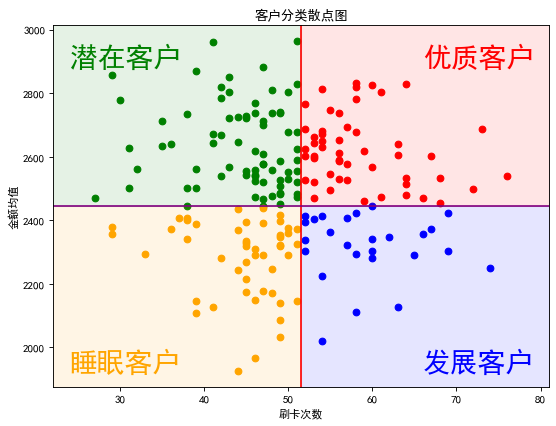

请选择要进行的操作：1：客户分类 2：客户画像 0：退出2


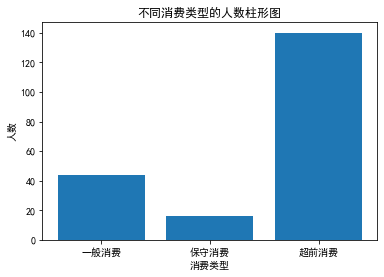

请选择要进行的操作：1：客户分类 2：客户画像 0：退出3
没有你输入的操作，请重新选择
请选择要进行的操作：1：客户分类 2：客户画像 0：退出0
退出操作


In [1]:
### 客户画像 和 客户分类功能函数化
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "SimHei"  # 正常显示中文
# 消除警告的命令
import warnings
warnings.filterwarnings("ignore")

# 打开表函数
def open_data_def():
    data_df = pd.read_csv("transactions.csv", encoding = "GBK")
    # 将列表题修改成中文的
    data_df.columns = ["客户号", "银行卡号", "刷卡金额", "刷卡时间", "卡类型"]
    # 数据清洗--检测和处理重复值
    if data_df.duplicated().sum():
        use_df = data_df.drop_duplicates()
    return use_df

# 添加时间函数
def add_time():
    use_df = open_data_def()  # 打开表函数
    # 统计和时间有关的数据类型
    # 1.先把时间转换为标准时间格式
    use_df["刷卡时间"] = pd.to_datetime(use_df["刷卡时间"])
    # 2.给表添加列年，月，日，时
    use_df["年"] = use_df["刷卡时间"].dt.year
    use_df["月"] = use_df["刷卡时间"].dt.month
    use_df["日"] = use_df["刷卡时间"].dt.day
    use_df["时"] = use_df["刷卡时间"].dt.hour
    return use_df

# 客户分类
def cust_type_def(use_df):
    # 统计每个客户的刷卡次数和消费金额平均值
    group_data = use_df.loc[:, ["客户号", "银行卡号", "刷卡金额"]].groupby("客户号")  # 分组
    stat_df = group_data.agg({"银行卡号":len, "刷卡金额":lambda x:np.round(np.mean(x), 2)}) # 聚合
    # 将表变成有三列信息的数据（客户号，刷卡次数，金额均值）
    stat_df = stat_df.reset_index(drop=False) # 重置行索引
    stat_df.columns = ["客户号", "刷卡次数", "金额均值"]
    # 绘制散点图（x轴是刷卡次数，y轴是金额均值）
    fig = plt.figure(figsize=(8,6), dpi=80)  # 绘制画布
    # 准备数据
    x_data = stat_df.loc[:, ["刷卡次数"]].values
    y_data = stat_df.loc[:, ["金额均值"]].values
    # 绘制图形
    xmin = np.min(x_data)
    xmax = np.max(x_data)
    x_center = (xmin+xmax)/2
    ymin = np.min(y_data)
    ymax = np.max(y_data)
    y_center = (ymin+ymax)/2
    ## 绘制十字线
    plt.axvline(x_center, color="red")
    plt.axhline((ymin+ymax)/2, color="purple")
    ## 四个不同的颜色的点
    for k in range(len(x_data)):
        if x_data[k] >= x_center and y_data[k] >= y_center:
            plt.scatter(x_data[k], y_data[k], color="red")
        elif x_data[k] >= x_center and y_data[k] < y_center:
            plt.scatter(x_data[k], y_data[k], color="blue")
        elif x_data[k] < x_center and y_data[k] >= y_center:
            plt.scatter(x_data[k], y_data[k], color="green")
        elif x_data[k] < x_center and y_data[k] < y_center:
            plt.scatter(x_data[k], y_data[k], color="orange")
    ## 填充四个象限的颜色
    plt.fill_between([x_center,xmax+5], y_center, ymax+50, color="red", alpha=0.1)
    plt.fill_between([xmin-5,x_center], y_center, ymax+50, color="green", alpha=0.1)
    plt.fill_between([xmin-5,x_center], y_center, ymin-50, color="orange", alpha=0.1)
    plt.fill_between([x_center,xmax+5], y_center, ymin-50, color="blue", alpha=0.1)
    ## 设置 x 轴 y 轴的范围
    plt.xlim(xmin-5, xmax+5)
    plt.ylim(ymin-50, ymax+50)
    ## 标签
    plt.title("客户分类散点图")
    plt.xlabel("刷卡次数")
    plt.ylabel("金额均值")
    ## 添加文字
    plt.text(xmax-10, ymax-80, "优质客户", fontsize=25, color="red")
    plt.text(xmin-3, ymax-80, "潜在客户", fontsize=25, color="green")
    plt.text(xmin-3, ymin, "睡眠客户", fontsize=25, color="orange")
    plt.text(xmax-10, ymin, "发展客户", fontsize=25, color="blue")
    # 显示保存图形
    plt.savefig("客户分类散点图.jpg")
    plt.show()

# 客户画像
def cust_marker_def(use_df):
    # 客户画像：根据信用卡刷卡次数的占比，来给客户贴标签（超前消费，一般消费，保守消费）
    # 消费刷卡次数的占比 = 信用卡刷卡次数 / 总的刷卡次数
    # 1，找出每个客户的总的刷卡次数
    group_data = use_df.loc[:, ["客户号", "银行卡号", "刷卡金额"]].groupby("客户号")  # 分组
    stat_df = group_data.agg({"银行卡号":len}) # 聚合
    #,2，找出使用信用卡的人数
    credit_df = use_df.loc[use_df["卡类型"]=="信用卡", ["客户号","银行卡号"]].groupby("客户号").agg({"银行卡号":len })
    # 3，找出stat_df中使用过信用卡的人，并把总的刷卡次数信息合并到crdit_df中
    credit_df["总次数"] = stat_df.loc[stat_df.index.isin(credit_df.index), :]
    # 4，找出stat_df中没有使用过信用卡的人，并把总的刷卡次数信息合并到crdit_df中
    uncredit_df = stat_df.loc[~stat_df.index.isin(credit_df.index), :]
    uncredit_df.columns = ["总次数"]
    # 5，给没有使用过信用卡的信息添加到信用卡使用次数为0
    uncredit_df["银行卡号"] = 0
    marker_data = pd.concat([credit_df, uncredit_df], axis=0).reset_index(drop=False)  # 拼接
    marker_data.columns = ["客户号", "信用卡刷卡次数", "总次数"]
    marker_data["信用卡使用占比"] = np.round(marker_data["信用卡刷卡次数"]/marker_data["总次数"], 2)
    # 要求1： 给客户贴标签，要求如下：
    # 占比 <= 0.4  保守消费
    # 占比 > 0.4 且 <=0.7  一般消费
    # 占比 > 0.7     超前消费
    marker_data["消费类型"] = "一般消费"
    marker_data.loc[marker_data["信用卡使用占比"]<=0.4, "消费类型"] = "保守消费"
    marker_data.loc[marker_data["信用卡使用占比"]>0.7, "消费类型"] = "超前消费"
    # 7，把结果保存到本地
    marker_data.to_excel("客户信用卡使用情况表.xlsx")
    # 8，统计每种消费类型的人数
    marker_df = marker_data.loc[:,["消费类型"]].groupby("消费类型").agg({"消费类型":len})
    # 9.用第8步的数据进行绘图 柱形图表示
    x_data = marker_df.index
    y_data = marker_df["消费类型"]
    plt.bar(x_data,y_data)
    ## 添加标签
    plt.title("不同消费类型的人数柱形图")
    plt.xlabel("消费类型")
    plt.ylabel("人数")
    ## 保存显示图形
    plt.savefig("不同消费类型的人数柱形图.jpg")
    plt.show()
    
# 主函数
def main():
    use_df = add_time()  # 调用添加时间信息函数
    while True:
        input_v2 = input("请选择要进行的操作：1：客户分类 2：客户画像 0：退出")
        if input_v2 == "0":
            print("退出操作")
            break
        elif input_v2 == "1":
            cust_type_def(use_df)  # 调用客户分类函数
        elif input_v2 == "2":
            cust_marker_def(use_df)  # 调用客户画像函数
        else:
            print("没有你输入的操作，请重新选择")
    
if __name__ == "__main__":
    main()